In [9]:
%load_ext autoreload
%autoreload 2
%reload_ext autoreload
%pip install pillow 
# animation saving

import os
import importlib
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import clear_output # Only for iPython

import solver as solve # solver
import objective as obj # objective function
import helper as help # helper functions
import parameters as param # parameters
from model import WormModel # worm model

# contraction engine
from contraction import ContractionEngine_segmentdriven
import contraction as contract

importlib.reload(obj)
importlib.reload(help)
importlib.reload(param)
importlib.reload(contract)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Note: you may need to restart the kernel to use updated packages.


<module 'contraction' from 'c:\\Users\\natha\\Desktop\\UCLA\\_Grad\\2025-2026\\FALL 2025\\MAE 263F\\MAE-263F\\final_report\\contraction.py'>

Single Worm Test

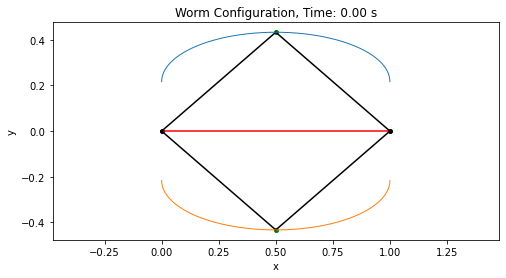

freeIndex:  [0 2 3 4 5 6]
fixedIndex:  [1, 7]
ndof:  8
q0:  [[ 0.         0.       ]
 [ 0.5        0.4330127]
 [ 0.5       -0.4330127]
 [ 1.         0.       ]]


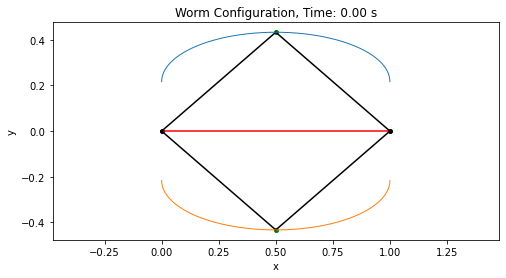

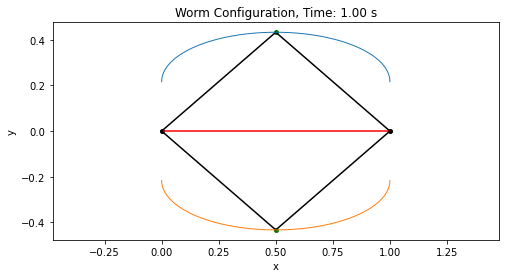

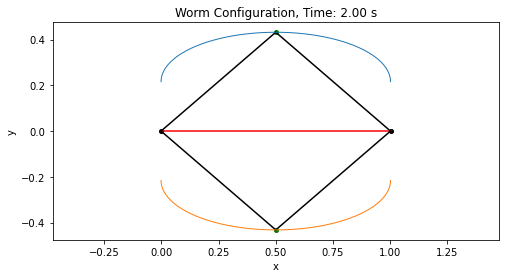

Animation: 200 total frames → 39 output frames
Playback: 1.99s sim time at 1.0x speed = 1.99s GIF
Animation saved to animations\worm1(22).gif


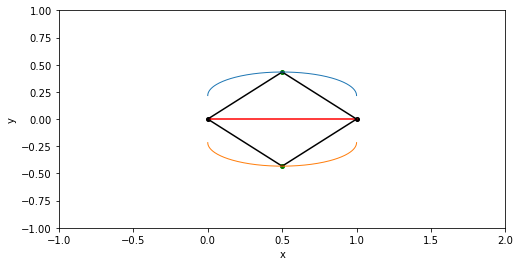

In [ ]:
worm1 = WormModel(name ="worm1", length=param.length, n_segments=1, fixedDOFs=[ 1, 7])
#worm1.plot()
# print('freeIndex: ', worm1.freeIndex)
# print('fixedIndex: ', worm1.fixedIndex)
# print('ndof: ', worm1.ndof)
# print('q0: ', worm1.q0)

frames, times = solve.solver(worm1, dt=param.dt, maxTime=2.0, tol=1e-7, maximum_iter=100)
ani = worm1.animate_worm(frames, times)


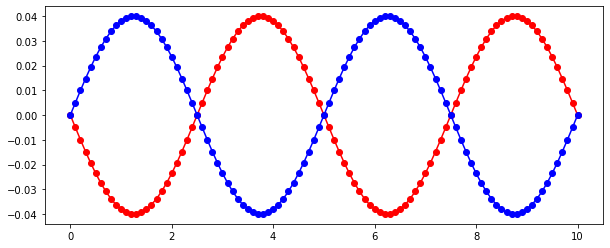

In [ ]:
dt = 0.1 # Time step size
maxTime = 10   # total time of simulation
t = np.arange(0, maxTime + dt, dt)

F_history = np.zeros((len(t), worm1.ndof))
for i, time in enumerate(t):
	F_history[i]  = contract.getContract_single_segment(worm1, time)

figure, ax = plt.subplots(figsize=(10, 4))
ax.plot(t , F_history[:, 3], 'o-', color='red')
ax.plot(t , F_history[:, 5], 'o-', color='blue')

# Worm Standing Wave Contraction Test

In [2]:
# 0,1, 2,3, 4,5, 6,7, 8,9 10,11 12,13, 14,15
worm6 = WormModel(name ="worm6", length=param.length, n_segments=param.n, fixedDOFs=[ 1,7,13,19,25,31,37])

NameError: name 'WormModel' is not defined

## Solver w/o predictor corrector

In [ ]:
print("Number of nodes (nv): ", worm6.nv)
print("Number of edges (ne): ", worm6.ne)
print("Number of DOFs (ndof): ", worm6.ndof)
#print(worm6.mMat[0,0], worm6.c[0,0])
#print("Initial position vector: ", worm6.q0)
#print("Initial velocity vector: ", worm6.u0)
#worm6.plot()

frames, times = solve.solver(worm6, dt=param.dt, maxTime=10, tol=1e-6, maximum_iter=100, contractType='multiple_segments')
# print(frames[0])
# print(times)
# print(len(frames))
# print(len(times))
# print(len(frames[0]))

ani = worm6.animate_worm(frames, times)


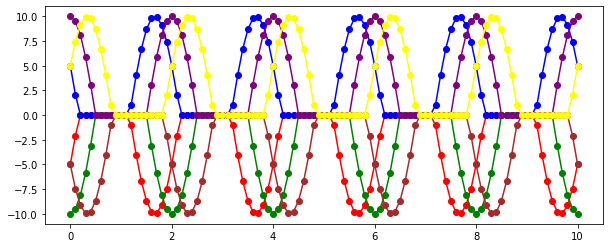

In [33]:
dt = 0.1 # Time step size
maxTime = 10   # total time of simulation
t = np.arange(0, maxTime + dt, dt)

F_history = np.zeros((len(t), worm6.ndof))
for i, time in enumerate(t):
	F_history[i]  = contract.getContract(worm6, time)

figure, ax = plt.subplots(figsize=(10, 4))
ax.plot(t , F_history[:, 3], 'o-', color='red')
ax.plot(t , F_history[:, 5], 'o-', color='blue')
ax.plot(t , F_history[:, 9], 'o-', color='green')
ax.plot(t , F_history[:, 11], 'o-', color='purple')
ax.plot(t , F_history[:, 15], 'o-', color='brown')
ax.plot(t , F_history[:, 17], 'o-', color='yellow')

## Solver with predictor corrector

In [41]:
print('Ground Position: ', worm6.groundPosition)

Ground Position:  -0.08216878364870321


In [ ]:
frames, times = solve.solver_with_predictor_corrector(worm6, dt=param.dt, maxTime=10, tol=1e-6, maximum_iter=100, contractType='multiple_segments')
ani = worm6.animate_worm(frames, times)


NameError: name 'solve' is not defined